<a id=top-page></a>
# Steady-state conduction in an insulated rod with internal heat production

The PDF version of this tutorial can be [downloaded here](https://github.com/kamilazdybal/fluid-dynamics-and-transport-phenomena/raw/master/transport-phenomena-with-Python/example-heat-transfer-in-a-rod.pdf).

<p style="font-size:10px">This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) license.</p>

Kamila Zdybał, 2021

<p style="font-size:10px">Université libre de Bruxelles, kamila.zdybal@ulb.ac.be</p>
<p style="font-size:10px"><a href="https://kamilazdybal.github.io/science-docs/">Science Docs</a>, kamila.zdybal@gmail.com</p>

***

### Table of contents

- [**Analytic solution**](#analytic)
- [**Numerical solution**](#numeric)
    - [**Finite Difference Method (FDM)**](#FDM)
- [**References**](#references)

***

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive

In [2]:
save_plots = False
line_color = '#0e2f44'
FDM_color = '#4fb49d'
FVM_color = '#d57211'
bar_color = '#767676'
help_lines = "#e5e5e5"

In [3]:
def plot_solution(x, T, x_approx=[], T_approx=[], approx_color=''):

    figure = plt.figure(figsize=(15, 4))
    ax1 = figure.add_subplot(1,1,1)
    plt.plot(x, T, color=line_color, linestyle='-', linewidth=4, zorder=1, label='Analytic')
    if len(x_approx) != 0:
        plt.plot(x_approx, T_approx, color=approx_color, marker='o', markersize=10, linestyle='-', linewidth=4, zorder=1, label='Numeric')
        plt.legend(fontsize=20, frameon=False)
    plt.xlabel('$x$ $[m]$', fontsize=20)
    plt.ylabel('$T(x)$ $[^o C]$', fontsize=20)
    plt.xlim(-0.05*L, 1.05*L)
    plt.ylim(-0.15*max(T), 1.1*max(T))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.margins(x=0)
    plt.rcParams['axes.xmargin'] = 0

    for y in np.arange(min(T), 1.1*max(T), 50):
        plt.plot([-0.05*L, 1.05*L], [y, y], "-", lw=1, color=help_lines, zorder=-1, alpha=0.4)

<a id=analytic></a>
***

## Analytic solution

[**Go to the top ↑**](#top-page)

We first derive an expression for the one-dimensional temperature distribution function $T(x)$, resulting from the steady-state heat conduction in a straight rod of length $L$. We assume that there is an internal heat production, $Q_p$ ($W/m^3$), at every point in the rod's volume. This may for instance simulate heating up of a wire due to electrical current. The rod is perfectly insulated along its length and it looses heat only through its endpoints (at $x=0$ and at $x=L$). At steady-state, these endpoints are kept at a fixed temperature, $T_0$. The material from which the rod is made has thermal conductivity $\lambda$ ($\frac{W}{mK}$). The system that we will study is presented in Fig.1a.

<img src="../figures/example-heat-transfer-in-a-rod-theory.svg" style="height:250px">

**Figure 1** (**a**) Conduction in a lengthwise-insulated rod with internal heat production. (**b**) An infinitesimal control volume (CV) extracted from the rod.

Let's start with writing out the energy balance for an infinitesimal control volume, CV, shown in Fig.1b. The CV is a slice of length $dx$ extracted from the rod. The energy balance for the CV can be written as
\begin{equation}
\frac{dE_{dx}}{dt} = E_{dx, in} - E_{dx, out} + E_{dx, production} .
\end{equation}
Note that $E_{dx, in}$, $E_{dx, out}$ and $E_{dx, production}$ are energies per unit time and so have the units of $W$. The heat flux, $\phi$ ($W$), can be modeled using the Fourier's law for one-dimensional heat conduction,
\begin{equation}
\phi = \lambda A \Big(- \frac{dT}{dx} \Big),
\label{eq:fourier}
\end{equation}
where $\lambda$ is the thermal conductivity and is a property of the material, $A$ is the rod's cross-sectional area and $\frac{dT}{dx}$ is the temperature gradient which can be thought of as the "driving force" for thermal energy transport. Hence:
\begin{equation}
E_{dx, in} = \lambda A \Big(- \frac{dT}{dx} \Big)_x ,
\end{equation}
\begin{equation}
E_{dx, out} = \lambda A \Big(- \frac{dT}{dx} \Big)_{x + dx} .
\end{equation}
The energy per unit time coming from the heat production can be written as $Q_p$ multiplied by the volume of the CV:
\begin{equation}
E_{dx, production} = Q_p A dx .
\end{equation}
At steady-state, $\frac{dE}{dt} = 0$ and the energy balance becomes
\begin{equation}
\lambda A \Big(- \frac{dT}{dx} \Big)_x - \lambda A \Big(- \frac{dT}{dx} \Big)_{x + dx} + Q_p A dx = 0 .
\end{equation}
Simplifying the above energy balance we get
\begin{equation*}
\frac{\Big(\frac{dT}{dx} \Big)_{x + dx} - \Big(\frac{dT}{dx} \Big)_x  }{dx} = - \frac{Q_p}{\lambda} .
\end{equation*}
It is interesting to note here, that we have lost the dependence on the cross-sectional area of the rod.
If we now substitute some function $f(x) = \frac{dT}{dx}$, we notice that we have
\begin{equation*}
\frac{f(x + dx) - f(x)}{dx} = - \frac{Q_p}{\lambda}
\end{equation*}
or, in other words,
\begin{equation}
\frac{df(x)}{dx} = - \frac{Q_p}{\lambda} .
\end{equation}
With the above substitution, the differential equation that we are about to solve becomes
\begin{equation}
\frac{d^2T}{dx^2} = - \frac{Q_p}{\lambda} .
\end{equation}
Applying the boundary conditions from both ends of the rod ($T(x=0) = T_0$ and $T(x=L) = T_0$), the solution to the above differential equation is
\begin{equation}
T(x) = - \frac{Q_p}{2 \lambda} (x^2 - Lx) + T_0 .
\label{eq:solution}
\end{equation}


Below, we draw a graph of the temperature distribution in a copper rod $200m$ long with cross-sectional area of $0.01m^2$. We assume that the thermal conductivity for this rod is $400 \frac{W}{m \cdot K}$. The internal heat production in the entire rod is $20 W$ and the steady-state temperature of the endpoints is kept at $T_0 = 0^o C$.

In [4]:
T0 = 0       # deg C
L = 200      # m
A = 0.01     # m^2 
Q = 20       # W
Qp = Q/(L*A) # W/m^3
𝝀 = 400      # W/(m*C)

# Discretize the rod:
x = np.linspace(0, L, 200)

# Analytic solution:
T = - Qp/(2*𝝀) * (x**2 - L * x) + T0

The analytic solution is plotted below:

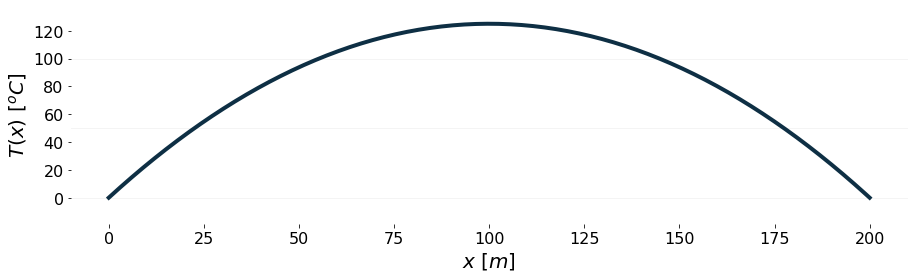

In [5]:
plot_solution(x, T)
if save_plots==True: plt.savefig('../figures/example-heat-transfer-in-a-rod-analytic.pdf', dpi = 500, bbox_inches='tight')

Note, that even though the heat flow was assumed to be one-dimensional in this exercise, it does not mean that the geometry of the problem has to be one-dimensional. In fact, we've assumed the rod to be a three-dimensional object having length and a cross-sectional area. Rather, the one-dimensionality of the problem means that it is practical to assume only one of the three directions as an important direction for heat transport. Since the rod was perfectly insulated along its length, the temperature gradients along directions perpendicular to the $x$-axis are zero.


<a id=numeric></a>
***

## Numerical solution

[**Go to the top ↑**](#top-page)

As a computational example, we are going to numerically solve a second-order linear ODE governing this problem:
$$\frac{d^2 T}{dx^2} = - \frac{Q_p}{\lambda}$$
with two Dirichlet boundary conditions: $T(x=0) = T_0$ and $T(x=L) = T_0$.

<a id=FDM></a>
### Finite Difference Method (FDM)

[**Go to the top ↑**](#top-page)

Using the second-order central difference approximation we have
\begin{equation}
\frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2} = - \frac{Q_p}{\lambda}, 
\end{equation}
which we can also write as 
\begin{equation}
T_{i-1} - 2 T_i + T_{i+1} = - \Delta x^2 \frac{Q_p}{\lambda}
\end{equation}
to have a better view for creating the matrix form of the system of equations. Having selected $n$ points that discretize the domain, we have $n$ algebraic equations to solve. In a matrix form those can be written as:
\begin{gather}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & \dots & 0 \\
1 & -2 & 1 & 0 & 0 & \dots & 0 \\
0 & 1 & -2 & 1 & 0 & \dots & 0 \\
\vdots \\
0 & 0 & 0 & 0 & 0 & \dots & 1 \\
\end{bmatrix}
\begin{bmatrix}
T_1  \\
T_2 \\
T_2 \\
\vdots \\
T_n \\
\end{bmatrix}
=
\begin{bmatrix}
T_0  \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
\vdots \\
T_0 \\
\end{bmatrix}
\end{gather}
Or in general as: $\mathbf{A} \mathbf{T} = \mathbf{R}$. Notice that the matrix $\mathbf{A}$ is a tridiagonal matrix. We will use that information to construct that matrix using `np.diag()` methods.

In [6]:
def solve_with_fdm(n_points):
    
    # Discretize the domain:
    x_FDM = np.linspace(0, L, n_points)
    dx = L/(n_points-1)

    # Construct three diagonals:
    upper_diagonal = np.ones(n_points-1)
    diagonal = - 2*np.ones(n_points)
    lower_diagonal = np.ones(n_points-1)

    # Set the boundary conditions:
    upper_diagonal[0] = 0
    diagonal[0] = 1
    diagonal[-1] = 1
    lower_diagonal[-1] = 0
    
    # Construct the matrix A from the three diagonals:
    A = np.diag(lower_diagonal, -1) + np.diag(diagonal, 0) + np.diag(upper_diagonal, 1)
    
    # Construct the right-hand-side matrix:
    R = np.ones(n_points) * (-dx**2*(Qp/𝝀))
    
    # Set the boundary conditions:
    R[0] = T0
    R[-1] = T0

    # Solve the system of equations:
    T_FDM = np.linalg.solve(A, R)
    
    plot_solution(x, T, x_FDM, T_FDM, FDM_color)

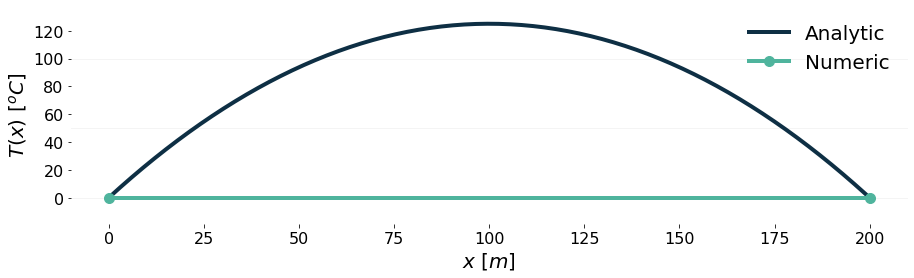

In [7]:
interact(solve_with_fdm, n_points=widgets.IntSlider(min=2, max=15, step=1, value=2));

The numerical solution using FDM is plotted below on top of the analytic solution using $n=5$ and then $n=10$ equations:

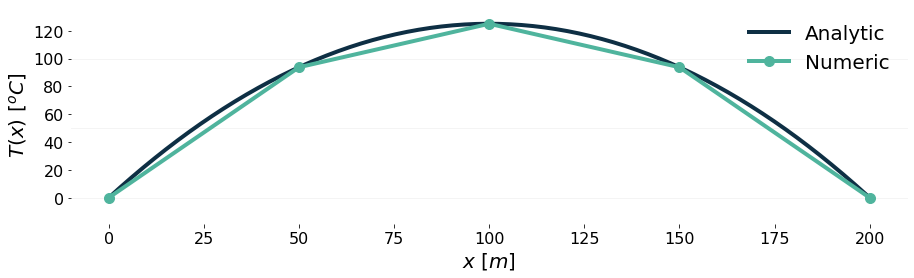

In [8]:
T_FDM = solve_with_fdm(5)
if save_plots==True: plt.savefig('../figures/example-heat-transfer-in-a-rod-FDM-n5.pdf', dpi = 500, bbox_inches='tight')

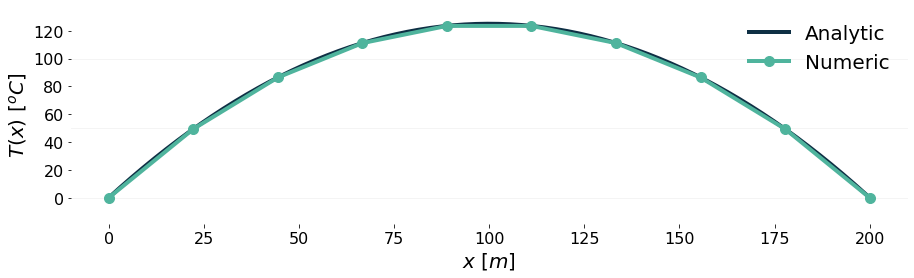

In [9]:
T_FDM = solve_with_fdm(10)
if save_plots==True: plt.savefig('../figures/example-heat-transfer-in-a-rod-FDM-n10.pdf', dpi = 500, bbox_inches='tight')

<a id=references></a>
***

## References

[**Go to the top ↑**](#top-page)

Below is a list of all learning materials that helped me put together this tutorial:

1. Robert Mudde, Peter Hamersma, *The Basics of Transport Phenomena*, Delft University of Technology, available on edX.org as DelftX: TP101x
2. Robert Mudde, Peter Hamersma, *Advanced Transport Phenomena*, Delft University of Technology, available on edX.org as DelftX: TP201x.
3. James C. Sutherland, [*Advanced Numerical Methods*](https://sutherland.che.utah.edu/teaching/chen6703/lectures-schedule/), The University of Utah, 2018
4. Joel H. Ferziger, Milovan Perić, Robert L. Street, *Computational Methods for Fluid Dynamics*, 3rd Edition, Springer-Verlag Berlin Heidelberg, 2002.

This material was adapted from material posted on the DelftX website, delftx.tudelft.nl, and created by TU Delft faculty members **Robert Mudde**, Professor of Multiphase Flow at the Dept. of Chemical Engineering and **Peter Hamersma**, Associate Professor at the Dept. of Chemical Engineering, 2015. DelftX is not responsible for any changes made to the original materials posted on its website and any such changes are the sole responsibility of Kamila Zdybał.

The course materials by Delft University of Technology are subjected to copyright and are licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International [Licence](https://creativecommons.org/licenses/by-nc-sa/4.0/).

***